In [12]:
from numpy.random.bit_generator import SeedlessSeedSequence
import tensorflow as tf
import os
import numpy as np
import random
from sklearn.utils import shuffle
#from tqdm import tqdm #Provides a progress bar while the images are being resized
from skimage.io import imshow, imread
from keras.models import Model
from skimage.transform import resize
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import tifffile as tiff 
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split
from patchify import patchify
from keras.optimizers import Adam
from sklearn.metrics import jaccard_score,  accuracy_score, f1_score, make_scorer, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import random
from keras.layers import Input, concatenate, Conv2D, MaxPooling3D, Conv3DTranspose, Flatten, Dense, BatchNormalization, Reshape, Conv3D
#%load_ext tensorboard
from keras import backend as K
seed =42
np.random.seed=42

from spectral import *

In [2]:
HEIGHT = 512
WIDTH = 512
CHANNELS = 10

In [3]:
X=[]
y=[]

for a in range(1,5):
  Xpath = '/Users/anshugusain/tf-nuclei/content/dataCubes/Field' + str(a) + '/cube_envi32.hdr'
  Ximg = spectral.open_image(Xpath)
  #Field = Ximg.read_bands((45,63,85,100,110))
  arr = np.array([37,38,39,40,41,42,43,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,128,129,130,131,132])

  for x in range(38,138):

    Field = Ximg.read_bands((x))
  
    ypath = '/Users/anshugusain/tf-nuclei/content/Field-00' + str(a) + '-mask-STARDIST.tif'
    yimg = tf.keras.preprocessing.image.load_img(ypath, grayscale=True)
    

    Xpatches = patchify(Field,(HEIGHT,WIDTH),step=HEIGHT)

    yimg = np.asarray(yimg)
    ypatches = patchify(yimg, (HEIGHT,WIDTH), step=HEIGHT)

    for m in range(0, Xpatches.shape[0]):
      for l in range(0, Xpatches.shape[1]):
       X.append(Xpatches[m,l])
       y.append(ypatches[m,l])

/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [437]:
X_test=[]
y_test=[]


Xpath = '/Users/anshugusain/tf-nuclei/content/dataCubes/Field5/cube_envi32.hdr'
Ximg = spectral.open_image(Xpath)
#Field = Ximg.read_bands((45,63,85,100,110))
arr = np.array([37,38,39,40,41,42,43,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,128,129,130,131,132])

for x in range(38,138):

  Field = Ximg.read_bands((x))

  ypath = '/Users/anshugusain/tf-nuclei/content/Field-005-mask-STARDIST.tif'
  yimg = tf.keras.preprocessing.image.load_img(ypath, grayscale=True)
  

  Xpatches = patchify(Field,(HEIGHT,WIDTH),step=HEIGHT)

  yimg = np.asarray(yimg)
  ypatches = patchify(yimg, (HEIGHT,WIDTH), step=HEIGHT)

  for m in range(0, Xpatches.shape[0]):
    for l in range(0, Xpatches.shape[1]):
      X_test.append(Xpatches[m,l])
      y_test.append(ypatches[m,l])

In [438]:
X = np.array(X)
y = np.array(y)>0
X_test = np.array(X_test)
y_test = np.array(y_test)>0

In [439]:
X = (X/X.max())
y = (y/y.max())
X_test = (X_test/X_test.max())
y_test = (y_test/y_test.max())

In [356]:
#X_train, X_test, y_train, y_test = train_test_split(X,y>0 ,random_state=42, test_size=0.10, shuffle=True)

In [440]:
X.shape

(400, 512, 512)

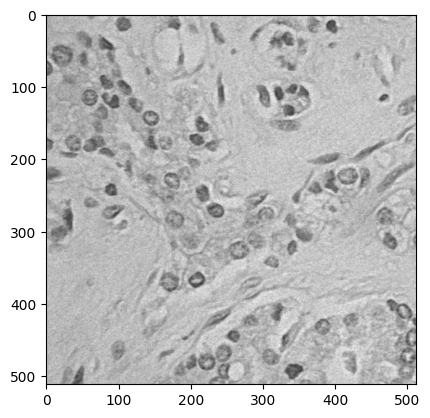

In [357]:
plt.imshow(X[len(X)-1],cmap='gray')

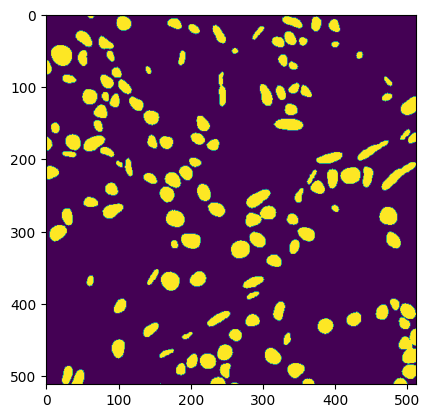

In [358]:
plt.imshow(y[len(y)-1])

In [359]:
IMG_HEIGHT = HEIGHT
IMG_WIDTH = WIDTH
#IMG_CHANNELS = CHANNELS


inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH,1))
#s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
s = inputs

#Contraction path
c1 = tf.keras.layers.Conv2D(10, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(10, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(20, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(20, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(40, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(40, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(80, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(40, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(40, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(40, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(20, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(20, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(20, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(10, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(10, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(10, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_363 (Conv2D)            (None, 512, 512, 10  100         ['input_27[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_171 (Dropout)          (None, 512, 512, 10  0           ['conv2d_363[0][0]']             
                                )                                                          

In [360]:
from tensorflow import keras 
from collections import deque

In [ ]:

class terminate_on_plateau(keras.callbacks.Callback):
    
    def __init__(self):
        self.patience = 10
        self.val_loss = deque([],self.patience)
        self.std_threshold = 1e-2
        
    def on_epoch_end(self,epoch,logs=None):
        val_loss,val_mae = model.evaluate(X_test,y_test)
        self.val_loss.append(val_loss)
        if len(self.val_loss) >= self.patience:
            std = np.std(self.val_loss)
            if std < self.std_threshold:
                print('\n\n EarlyStopping on std invoked! \n\n')
                # clear the deque
                self.val_loss = deque([],self.patience)
                model.stop_training = True
    

results = model.fit(X, y, validation_data=(X_test, y_test), batch_size = 1, epochs=20, verbose=0, shuffle=False, callbacks=[terminate_on_plateau()])

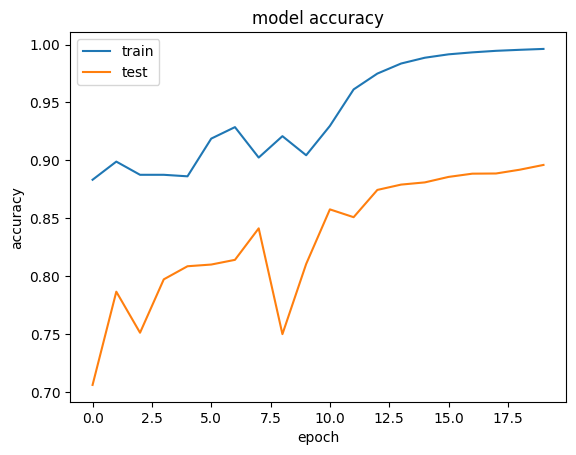

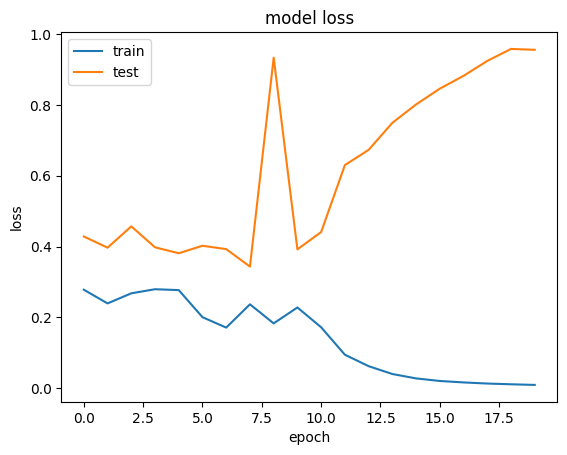

In [362]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [363]:
def average_calc(X_examine, y_examine):
  IoUs = [len(X_examine)]
  total =0
  average =0

  for i in range(0,len(X_examine)):
    test_predict = model.predict(np.expand_dims(X_examine[i],0))
    test_predict = np.asarray(test_predict) 
    IoU = jaccard_score((test_predict>0.6).squeeze(), (y_examine[i]>0).squeeze(), average='micro')
    total =IoU + total
  average = total / len(X_examine)
  
  return average

In [364]:
average_calc(X_test, y_test)

2023-06-27 11:09:51.250287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step


0.5486381762787325

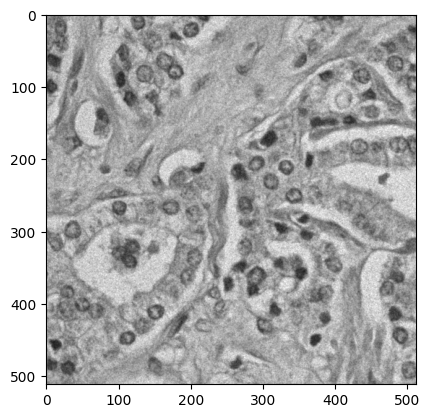

In [368]:
plt.imshow(X_test[0],cmap='gray')

1/1 [==============================] - 0s 22ms/step


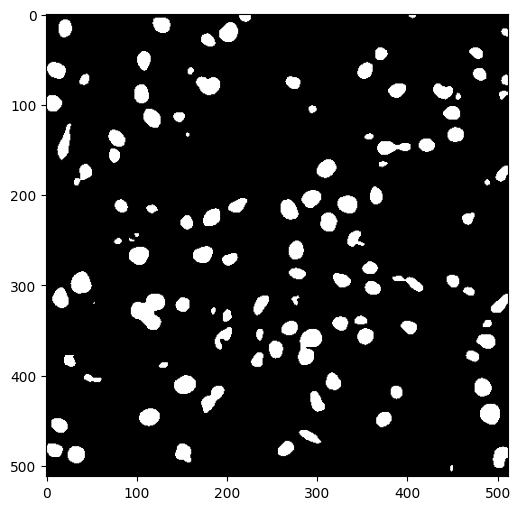

In [371]:
test_predict = model.predict(np.expand_dims(X_test[0],0))
test_predict = np.asarray(test_predict)
plt.figure(figsize=(10,6))
plt.imshow(test_predict.squeeze()>0.5,cmap='gray')

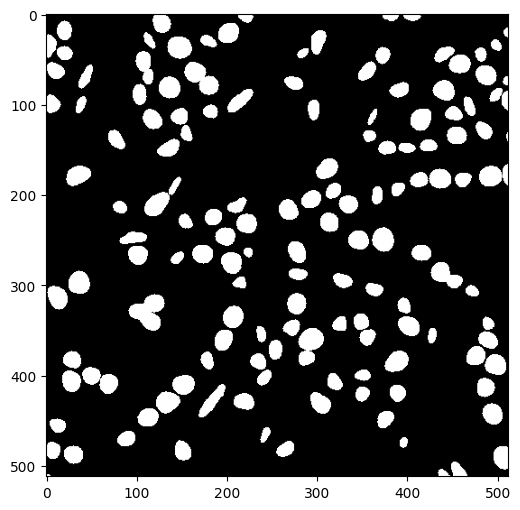

In [372]:
plt.figure(figsize=(10,6))
plt.imshow(y_test[0].squeeze(),cmap='gray')

In [28]:
X=[]
y=[]

for a in range(1,6):
  Xpath = '/Users/anshugusain/tf-nuclei/content/dataCubes/Field' + str(a) + '/cube_envi32.hdr'
  Ximg = spectral.open_image(Xpath)
  #Field = Ximg.read_bands((45,63,85,100,110))
  Field = Ximg.read_bands((45,46,88,97,98,102,119,122,123,136))
  
  ypath = '/Users/anshugusain/tf-nuclei/content/Field-00' + str(a) + '-mask-STARDIST.tif'
  yimg = tf.keras.preprocessing.image.load_img(ypath, grayscale=True)
    

  Xpatches = patchify(Field,(HEIGHT,WIDTH,CHANNELS),step=HEIGHT)

  yimg = np.asarray(yimg)
  ypatches = patchify(yimg, (HEIGHT,WIDTH), step=HEIGHT)

  for m in range(0, Xpatches.shape[0]):
    for l in range(0, Xpatches.shape[1]):
      X.append(Xpatches[m,l,0])
      y.append(ypatches[m,l])

In [29]:
X = np.array(X)
y = np.array(y)

In [30]:
X = (X/X.max())
y = (y/y.max())

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y>0 ,random_state=42, test_size=0.10, shuffle=True)

In [32]:
#X_train = np.expand_dims(X_train,-1)
#X_train = np.expand_dims(X_train,0)

In [33]:
#y_train = np.expand_dims(y_train,-1)

In [34]:
X_train.shape, y_train.shape

((4, 512, 512, 10), (4, 512, 512))

In [2]:
HEIGHT = 512
WIDTH = 512
CHANNELS = 10

In [5]:
IMG_HEIGHT = HEIGHT
IMG_WIDTH = WIDTH
IMG_CHANNELS = CHANNELS


inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,1))
#s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
s = inputs

#Contraction path
c1 = tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(s)
#c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling3D((2,2,2))(c1)

c2 = tf.keras.layers.Conv3D(64, (3, 3,3), activation='relu', padding='same')(p1)
#c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv3D(64, (3, 3,3), activation='relu', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling3D((2, 2,2))(c2)

c3 = tf.keras.layers.Conv3D(128, (3, 3,3), activation='relu', padding='same')(p2)
#c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv3D(128, (3, 3,3), activation='relu', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling3D((2, 2,2))(c3)

c4 = tf.keras.layers.Conv3D(256, (3, 3,3), activation='relu', padding='same')(p3)
#c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(c4)


flat6 = Flatten()(c4)
output_1 = Dense(8, activation='softmax', name='output_1')(flat6)


#Expansive path
u6 = tf.keras.layers.Conv3DTranspose(128, (2,2,2), strides=(2, 2,2), padding='same')(c4)
u6 = tf.keras.layers.concatenate([u6, c3])
c6 = tf.keras.layers.Conv3D(128, (3,3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv3D(128, (3, 3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv3DTranspose(64, (2,2,2), strides=(2, 2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c2], axis =3)
c7 = tf.keras.layers.Conv3D(64, (3, 3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv3D(64, (3, 3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv3DTranspose(32, (2, 2,2), strides=(2, 2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c1], axis =3)
c8 = tf.keras.layers.Conv3D(32, (3, 3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv3D(32, (3, 3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

"""
u9 = tf.keras.layers.Conv3DTranspose(16, (2, 2,2), strides=(2, 2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv3D(16, (3, 3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv3D(16, (3, 3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
"""

conv3d_shape = c8.shape

c8 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(c8)

output_2 = Conv2D(1, (1, 1), activation='softmax', name='output_2')(c8)

model = Model(inputs=[inputs], outputs=[ output_2])

model.compile(optimizer=Adam(lr=0.001), loss={'output_2': 'categorical_crossentropy'}, metrics=['accuracy'])

2023-06-28 00:11:49.293905: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-28 00:11:49.293934: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                0, 1)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 512, 512, 10  896         ['input_1[0][0]']                
                                , 32)                                                             
                                                                                                  
 conv3d_1 (Conv3D)              (None, 512, 512, 10  27680       ['conv3d[0][0]']                 
                                , 32)                                                         

In [47]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

2023-06-28 00:09:28.927332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-06-27 23:51:00.709911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 8s 8s/step


TypeError: Invalid shape (512, 512, 28) for image data

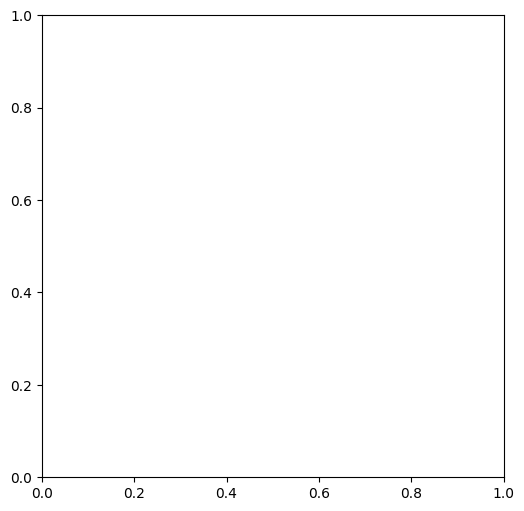

In [15]:
test_predict = model.predict(np.expand_dims(X_test[0],0))
test_predict = np.asarray(test_predict)
plt.figure(figsize=(10,6))
plt.imshow(test_predict.squeeze()>0.5,cmap='gray')

In [16]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                0, 1)]                                                            
                                                                                                  
 conv3d_28 (Conv3D)             (None, 512, 512, 30  896         ['input_5[0][0]']                
                                , 32)                                                             
                                                                                                  
 conv3d_29 (Conv3D)             (None, 512, 512, 30  27680       ['conv3d_28[0][0]']              
                                , 32)                                                       